# Email Classification 

## Classify the incoming emails in to multiple categories

### Import all the required libraries

In [2]:
''' Import libraries for dataset preparation, feature engineering, model training '''

''' import pandas '''
import pandas as pd 

''' import reader() from csv '''
from csv import reader

''' Load matplotlib as 'plt' '''
import matplotlib.pyplot as plt

''' Natural Language Toolkit: nltk '''
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

''' scikit learn : sklearn libraries '''
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

''' NumPy library '''
import numpy as np

''' itertools library '''
import itertools

### Dataset preparation

In [8]:
## Read data from the dataset 'consumer_complaint_new.csv' 
## This creates a Pandas DataFrame "df_comp_data"

df_comp_data = pd.read_csv("consumer_complaints_new.csv")

In [9]:
## Obtain length of the dataframe "df_comp_data"

print 'Total Number of Records : ', len(df_comp_data)

Total Number of Records :  362322


In [10]:
## For this model (categorization/classification), we need only 2 columns. 
## Hence pull out only the 2 columns "proudct", "consumer complaint narrative" from the dataset

cols = ['product', 'consumer_complaint_narrative']

## Create a new DataFrame having only the columns "product" & "consumer_complaint_narrative" 
df_comp_data_new = df_comp_data[cols]

## Ensure the dataset now contains only 2 columns
print df_comp_data_new.head(n=2)
print '\n'

## The independent variable "consumer_complaint_narrative" has "null"/NaN (missing values) value in many observations
## Remove all the observations with variable "consumer_complaint_narrative" having "null"/NaN (missing values)
df_comp_data_new = df_comp_data_new[pd.notnull(df_comp_data_new['consumer_complaint_narrative'])]

## Obtain new length of the dataframe "df_comp_data_new"
print 'Number of Observations : ', len(df_comp_data_new)
print '\n'

## Lets look at the data - display first 5 observations
print df_comp_data_new.head()
print '\n'

## The dataset contains 55557 observations and 2 columns
df_comp_data_new.shape

           product consumer_complaint_narrative
0  Debt collection                          NaN
1         Mortgage                          NaN


Number of Observations :  55557


               product                       consumer_complaint_narrative
39975  Debt collection  XXXX has claimed I owe them {$27.00} for XXXX ...
39983    Consumer Loan  Due to inconsistencies in the amount owed that...
40003         Mortgage  In XX/XX/XXXX my wages that I earned at my job...
40054         Mortgage  I have an open and current mortgage with Chase...
40055         Mortgage  XXXX was submitted XX/XX/XXXX. At the time I s...




(55557, 2)

In [12]:
## Select and process only first 1000 records
df_comp_data_new = df_comp_data_new.head(n=1000)

print df_comp_data_new.shape

(1000, 2)


### Exploratory Data Analysis

Debt collection            285
Mortgage                   235
Credit reporting           147
Credit card                121
Bank account or service     78
Consumer Loan               57
Student loan                47
Money transfers             17
Payday loan                 13
Name: product, dtype: int64


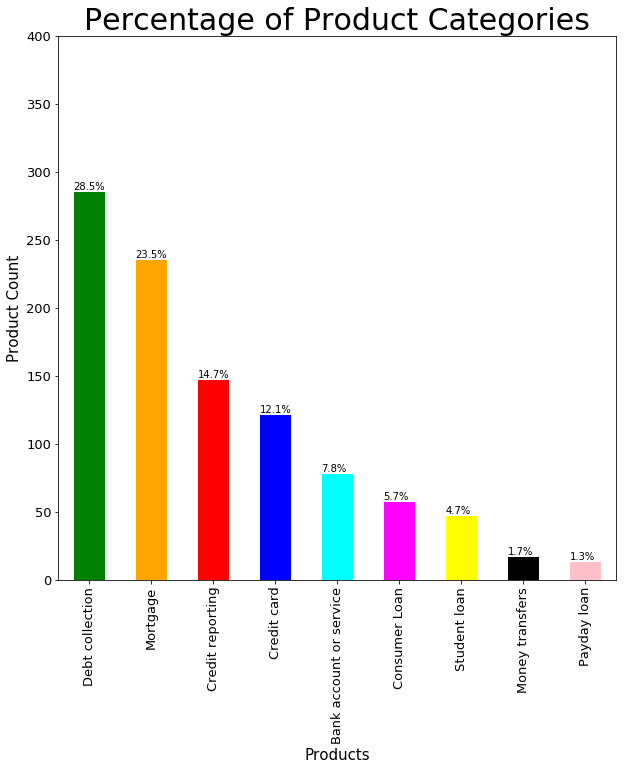

In [13]:
## Make plots of DataFrame using matplotlib
## count of products
product_count = pd.value_counts(df_comp_data_new["product"], sort= True)

## The below returns "axes : matplotlib.AxesSubplot"
ax = product_count.plot(kind='bar', figsize=(10,10), color= ["green", "orange", "red", "blue", "cyan", "magenta", "yellow", "black", "pink", "violet"], fontsize=13)

## Set the Bar Chart Title
ax.set_title("Percentage of Product Categories", fontsize=30)

## Set the Bar Chart Y-AXIS label
ax.set_ylabel("Product Count", fontsize=15);

## Set the Bar Chart X-AXIS label
ax.set_xlabel("Products", fontsize=15);

## Set the Bar Chart Y-AXIS ticks
ax.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])

## Create a list having total messages for each Product
totals = []
for i in ax.patches:
    totals.append(i.get_height())

## Total number of messages for all Product
total = sum(totals)

# set individual bar lables (in percent) using above list
for i in ax.patches:
    height = float(i.get_height())
    string = str(round((height / total) * 100, 2)) + '%'
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height(), string, fontsize=10, color='black', va='bottom')


print product_count
#print totals
#print total

### How the products are distributed

In [15]:
# Codifying the "product" values with numerical values
c = df_comp_data_new['product'].astype('category')

category_dict = dict(enumerate(c.cat.categories))
print category_dict
print ('\n')

# Ensure that the codifying is done correctly and map them
df_comp_data_new['product_code'] = df_comp_data_new['product'].astype('category').cat.codes
df_comp_data_new['product'] = df_comp_data_new['product_code'].map(category_dict)

# Ensure that product and product_code mapping is done correctly
product_count = pd.value_counts(df_comp_data_new["product_code"], sort= True)
print product_count
print ('\n')

# Ensure that the column "product_code" is included
df_comp_data_new.head()

{0: 'Bank account or service', 1: 'Consumer Loan', 2: 'Credit card', 3: 'Credit reporting', 4: 'Debt collection', 5: 'Money transfers', 6: 'Mortgage', 7: 'Payday loan', 8: 'Student loan'}


4    285
6    235
3    147
2    121
0     78
1     57
8     47
5     17
7     13
Name: product_code, dtype: int64




,product,consumer_complaint_narrative,product_code
39975,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,4
39983,Consumer Loan,Due to inconsistencies in the amount owed that...,1
40003,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,6
40054,Mortgage,I have an open and current mortgage with Chase...,6
40055,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,6


### Data Preparation & Cleaning

In [16]:
product_code_df = df_comp_data_new[['product', 'product_code']].drop_duplicates().sort_values('product_code')

print product_code_df['product'].values

['Bank account or service' 'Consumer Loan' 'Credit card'
 'Credit reporting' 'Debt collection' 'Money transfers' 'Mortgage'
 'Payday loan' 'Student loan']


#### Removing Numbers

In [17]:
# Remove numbers in a Data Frame column 'consumer_complaint_narrative'

def remove_numbers(text):
    return ''.join([i for i in text if not i.isdigit()])

In [18]:
df_comp_data_new['consumer_complaint_narrative'] = df_comp_data_new['consumer_complaint_narrative'].apply(remove_numbers)

In [19]:
df_comp_data_new.head()

,product,consumer_complaint_narrative,product_code
39975,Debt collection,XXXX has claimed I owe them {$.} for XXXX year...,4
39983,Consumer Loan,Due to inconsistencies in the amount owed that...,1
40003,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,6
40054,Mortgage,I have an open and current mortgage with Chase...,6
40055,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,6


#### Removing Special Characters

In [20]:
# Removing special characters
bad_chars = ["XXXX", "XX"]

def remv_sp_char(consumer_complaint_text):
    for char in bad_chars:
        consumer_complaint_text = consumer_complaint_text.replace(char, "")
    return consumer_complaint_text

In [21]:
df_comp_data_new['consumer_complaint_narrative'] = df_comp_data_new['consumer_complaint_narrative'].apply(remv_sp_char)

In [22]:
df_comp_data_new.head()

,product,consumer_complaint_narrative,product_code
39975,Debt collection,has claimed I owe them {$.} for years despit...,4
39983,Consumer Loan,Due to inconsistencies in the amount owed that...,1
40003,Mortgage,In // my wages that I earned at my job decreas...,6
40054,Mortgage,I have an open and current mortgage with Chase...,6
40055,Mortgage,was submitted //. At the time I submitted thi...,6


#### Perform Stemming

In [23]:
#create an object of class PorterStemmer
porter = PorterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [24]:
df_comp_data_new['consumer_complaint_narrative'] = df_comp_data_new['consumer_complaint_narrative'].apply(stemSentence)

In [25]:
df_comp_data_new.head()

,product,consumer_complaint_narrative,product_code
39975,Debt collection,ha claim I owe them { $ . } for year despit th...,4
39983,Consumer Loan,due to inconsist in the amount owe that I wa t...,1
40003,Mortgage,In // my wage that I earn at my job decreas by...,6
40054,Mortgage,I have an open and current mortgag with chase ...,6
40055,Mortgage,wa submit // . At the time I submit thi compla...,6


#### Removing Punctuations, convert text to lowercase and remove stop words, Lemmatize

In [26]:
lemmatizer = WordNetLemmatizer()

# Defining a function to remove punctuations, convert text to lowercase and remove stop words
def text_processing(text):
    no_punctuations = [char for char in text if char not in '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~']
    no_punctuations = ''.join(no_punctuations)

    clean_words = [word.lower() for word in no_punctuations.split() if word.lower() not in stopwords.words('english')]
    clean_words = [lemmatizer.lemmatize(lem) for lem in clean_words]
    clean_words = " ".join(clean_words)

    return clean_words

In [27]:
df_comp_data_new['consumer_complaint_narrative'] = df_comp_data_new['consumer_complaint_narrative'].apply(text_processing)

In [28]:
df_comp_data_new.head()

,product,consumer_complaint_narrative,product_code
39975,Debt collection,ha claim owe year despit proof payment sent ca...,4
39983,Consumer Loan,due inconsist amount owe wa told bank amount w...,1
40003,Mortgage,wage earn job decreas almost half knew wa trou...,6
40054,Mortgage,open current mortgag chase bank chase report l...,6
40055,Mortgage,wa submit time submit thi complaint dealt rush...,6


### Train Test Split

In [29]:
X = df_comp_data_new.loc[:,'consumer_complaint_narrative']
Y = df_comp_data_new.loc[:,'product_code']
Y = Y.astype('int')

In [30]:
## Splitting the dataset 
## Train - 70% & Test - 30%
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=1)

In [32]:
## Ensure that the split worked successfully
print 'Number of Observations (Indepedent) (Train) :', len(X_train)
print 'Number of Observations (Depedent) (Train) :', len(Y_train)

print 'Number of Observations (Indepedent) (Test) :', len(X_test)
print 'Number of Observations (Depedent) (Test) :', len(Y_test)
print '\n'

## product and product_code mapping
YY_test = Y_test.to_frame()
pdt_count = pd.value_counts(YY_test["product_code"], sort= True)
print pdt_count
print ('\n')

Number of Observations (Indepedent) (Train) : 700
Number of Observations (Depedent) (Train) : 700
Number of Observations (Indepedent) (Test) : 300
Number of Observations (Depedent) (Test) : 300


4    83
6    71
3    48
2    32
0    26
1    18
8    12
5     6
7     4
Name: product_code, dtype: int64




##  Feature Extraction

### Convert Text to Vectors using Count Vectorizer

#### Count Vectors as features

In [33]:
## create a count vectorizer
## Tokenize the documents and count the occurrences of token and return them as a sparse matrix
count_vectorizer = CountVectorizer()

## Learn the vocabulary dictionary and return term-document matrix (train)
count_train = count_vectorizer.fit_transform(X_train)
#print count_train.shape

## Create a dataframe for count, features
count_train_df = pd.DataFrame(count_train.toarray(), columns=count_vectorizer.get_feature_names())
#print "Vocabulary : " +str(count_vectorizer.vocabulary_)+'\n\n'
#print count_train_df

## Transform documents to document-term matrix 
count_test = count_vectorizer.transform(X_test)
#print count_test.shape

count_test_df = pd.DataFrame(count_test.toarray(), columns=count_vectorizer.get_feature_names())
#print(count_test_df)

### Fitting a Naive Bayes model (Count Vectorizer Data)

In [34]:
## Create a method
nb = MultinomialNB()

## Fit/Train Naive Bayes Classifier according to X, y
naive_bayes = nb.fit(count_train, Y_train)

## Perform classification on an array of vectors - Training Dataset
nb_pred_train = nb.predict(count_train)
## Perform classification on an array of vectors - Test Dataset
nb_pred_test = nb.predict(count_test)

## Calculate Accuracy of the Prediction
print('The accuracy for training data is {}'.format(nb.score(count_train, Y_train)))
print('The accuracy for testing data is {}'.format(nb.score(count_test, Y_test)))
print '\n'
print(accuracy_score(Y_test, nb_pred_test))

The accuracy for training data is 0.892857142857
The accuracy for testing data is 0.713333333333


0.7133333333333334


### Statistics (Naive Bayes Model - Count Vectorizer) - Training Dataset

In [35]:
print(classification_report(Y_train, nb_pred_train, target_names=product_code_df['product'].values))

                         precision    recall  f1-score   support

Bank account or service       0.94      0.85      0.89        52
          Consumer Loan       1.00      0.72      0.84        39
            Credit card       0.82      0.92      0.87        89
       Credit reporting       0.91      0.89      0.90        99
        Debt collection       0.89      0.95      0.92       202
        Money transfers       1.00      0.36      0.53        11
               Mortgage       0.89      0.98      0.93       164
            Payday loan       1.00      0.22      0.36         9
           Student loan       0.93      0.71      0.81        35

              micro avg       0.89      0.89      0.89       700
              macro avg       0.93      0.73      0.78       700
           weighted avg       0.90      0.89      0.89       700



### Statistics (Naive Bayes Model - Count Vectorizer) - Test Dataset

In [37]:
print(classification_report(Y_test, nb_pred_test, target_names=product_code_df['product'].values))

                         precision    recall  f1-score   support

Bank account or service       0.79      0.42      0.55        26
          Consumer Loan       0.80      0.22      0.35        18
            Credit card       0.66      0.78      0.71        32
       Credit reporting       0.74      0.54      0.63        48
        Debt collection       0.75      0.92      0.82        83
        Money transfers       0.00      0.00      0.00         6
               Mortgage       0.68      0.97      0.80        71
            Payday loan       0.00      0.00      0.00         4
           Student loan       0.75      0.25      0.38        12

              micro avg       0.71      0.71      0.71       300
              macro avg       0.57      0.46      0.47       300
           weighted avg       0.70      0.71      0.68       300



In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.tight_layout()

### Confusion Matrix - Naive Bayes (Count Vectorizer) - Test Dataset

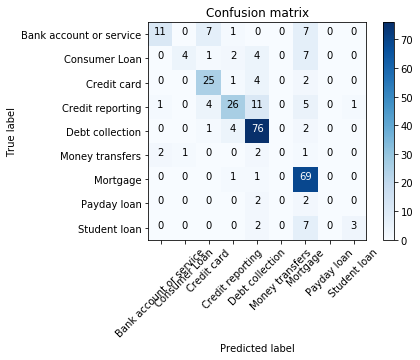

<Figure size 800x800 with 0 Axes>

In [39]:
target_names = product_code_df['product'].values

#Pass actual & predicted values to the confusion matrix() - Train
#cm = confusion_matrix(Y_train, nb_pred_train)

#Pass actual & predicted values to the confusion matrix() - Test
cm = confusion_matrix(Y_test, nb_pred_test)
#plt.figure()
plot_confusion_matrix(cm, classes=target_names)
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='g', edgecolor='k')
plt.show()

### Predict (An Example)

In [40]:
## Prediction
pred_value = naive_bayes.predict(count_vectorizer.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]))

pred_val_int = int(pred_value)

print "The predicted category is : ", category_dict[pred_val_int]

The predicted category is :  Debt collection


### Convert Text to Tfidf Vectors using Tfidf Vectorizer

In [41]:
## Convert a collection of raw documents to a matrix of TF-IDF features
## Term Frequency - Inverse Data/Document Frequency

tfidf_vectorizer = TfidfVectorizer()

## Learn vocabulary and idf, return term-document matrix (Train)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

#print tfidf_train.shape
tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns=tfidf_vectorizer.get_feature_names())
#print tfidf_train_df

## Transform documents to document-term matrix (Test)
tfidf_test = tfidf_vectorizer.transform(X_test)
#print tfidf_test.shape

tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf_vectorizer.get_feature_names())

#print(tfidf_train_df)

### Fitting a Naive Bayes model (TF IDF Data)

In [42]:
## Fit/Train Naive Bayes classifier according to X, y
naive_bayes_tfidf = nb.fit(tfidf_train, Y_train)

## Perform classification on an array of vectors - Training Dataset
nb_tfidf_pred_train = nb.predict(tfidf_train)

## Perform classification on an array of vectors - Test Dataset
nb_tfidf_pred_test = nb.predict(tfidf_test)

## Calculate Accuracy of the Prediction
print('The accuracy for training data is {}'.format(nb.score(tfidf_train, Y_train)))
print('The accuracy for testing data is {}'.format(nb.score(tfidf_test, Y_test)))
print '\n'
print(accuracy_score(Y_test, nb_tfidf_pred_test))

The accuracy for training data is 0.58
The accuracy for testing data is 0.503333333333


0.5033333333333333


### Statistics (Naive Bayes Model - Tfidf Vectorizer) - Training Dataset

In [43]:
print(classification_report(Y_train, nb_tfidf_pred_train, target_names=product_code_df['product'].values))

                         precision    recall  f1-score   support

Bank account or service       0.00      0.00      0.00        52
          Consumer Loan       0.00      0.00      0.00        39
            Credit card       0.94      0.18      0.30        89
       Credit reporting       1.00      0.26      0.42        99
        Debt collection       0.47      1.00      0.64       202
        Money transfers       0.00      0.00      0.00        11
               Mortgage       0.71      0.99      0.83       164
            Payday loan       0.00      0.00      0.00         9
           Student loan       0.00      0.00      0.00        35

              micro avg       0.58      0.58      0.58       700
              macro avg       0.35      0.27      0.24       700
           weighted avg       0.56      0.58      0.48       700



### Statistics (Naive Bayes Model - Tfidf Vectorizer) - Test Dataset

In [44]:
print(classification_report(Y_test, nb_tfidf_pred_test, target_names=product_code_df['product'].values))

                         precision    recall  f1-score   support

Bank account or service       0.00      0.00      0.00        26
          Consumer Loan       0.00      0.00      0.00        18
            Credit card       1.00      0.03      0.06        32
       Credit reporting       1.00      0.06      0.12        48
        Debt collection       0.44      1.00      0.61        83
        Money transfers       0.00      0.00      0.00         6
               Mortgage       0.59      0.90      0.71        71
            Payday loan       0.00      0.00      0.00         4
           Student loan       0.00      0.00      0.00        12

              micro avg       0.50      0.50      0.50       300
              macro avg       0.34      0.22      0.17       300
           weighted avg       0.53      0.50      0.36       300



### Confusion Matrix - Naive Bayes (Tfidf Vectorizer)

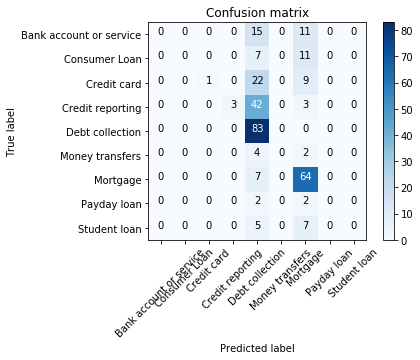

<Figure size 800x800 with 0 Axes>

In [45]:
## Check TP,TN,FP,FN
target_names = product_code_df['product'].values

## Pass actual & predicted values to the confusion matrix() - Test
cm = confusion_matrix(Y_test, nb_tfidf_pred_test)
#plt.figure()
plot_confusion_matrix(cm, classes=target_names)
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='g', edgecolor='k')
plt.show()

### Logistic Regression using Count data (Count Vectorizer)

In [47]:
## Create a method
lr = LogisticRegression()

## Fit Logistic Regression classifier according to X, y
logistic_regression = lr.fit(count_train, Y_train)

## Perform classification on an array of vectors - Training Dataset
lr_pred_train = lr.predict(count_train)
## Perform classification on an array of vectors - Test Dataset
lr_pred_test = lr.predict(count_test)

## Print the mean accuracy on the given test data and labels
print('The accuracy for training data is {}'.format(lr.score(count_train, Y_train)))
print('The accuracy for testing data is {}'.format(lr.score(count_test, Y_test)))
print '\n'
print(accuracy_score(Y_test, lr_pred_test))

The accuracy for training data is 0.998571428571
The accuracy for testing data is 0.753333333333


0.7533333333333333


### Logistic Regression using Tfidf Data (Tfidf Vectorizer)

In [48]:
## Create a method
lr = LogisticRegression()

## Fit Logistic Regression classifier according to X, y
logistic_regression = lr.fit(tfidf_train, Y_train)

## Perform classification on an array of Tfidf vectors - Training Dataset
lr_tfidf_pred_train = lr.predict(tfidf_train)
## Perform classification on an array of Tfidf vectors - Test Dataset
lr_tfidf_pred_test = lr.predict(tfidf_test)

## Prediction Score/Accuracy
print('The accuracy for training data is {}'.format(lr.score(tfidf_train, Y_train)))
print('The accuracy for testing data is {}'.format(lr.score(tfidf_test, Y_test)))
print '\n'
print(accuracy_score(Y_test, lr_tfidf_pred_test))

The accuracy for training data is 0.841428571429
The accuracy for testing data is 0.693333333333


0.6933333333333334


### Statistics (Logistic Regression - Count Vectorizer) - Test Dataset

In [49]:
print(classification_report(Y_test, lr_pred_test, target_names=product_code_df['product'].values))

                         precision    recall  f1-score   support

Bank account or service       0.68      0.65      0.67        26
          Consumer Loan       1.00      0.56      0.71        18
            Credit card       0.69      0.62      0.66        32
       Credit reporting       0.67      0.67      0.67        48
        Debt collection       0.76      0.88      0.82        83
        Money transfers       1.00      0.50      0.67         6
               Mortgage       0.81      0.90      0.85        71
            Payday loan       0.00      0.00      0.00         4
           Student loan       0.78      0.58      0.67        12

              micro avg       0.75      0.75      0.75       300
              macro avg       0.71      0.60      0.63       300
           weighted avg       0.75      0.75      0.74       300



### Confusion Matrix - Logistic Regression (Count Vectorizer) - Test Dataset

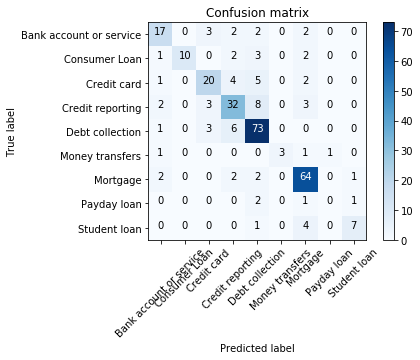

<Figure size 800x800 with 0 Axes>

In [50]:
## Check TP,TN,FP,FN
target_names = product_code_df['product'].values

## Pass actual & predicted values to the confusion matrix() - Test
cm = confusion_matrix(Y_test, lr_pred_test)
#plt.figure()
plot_confusion_matrix(cm, classes=target_names)
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='g', edgecolor='k')
plt.show()

### Statistics (Logistic Regression - Tfidf Vectorizer) - Test Dataset

In [206]:
print(classification_report(Y_test, lr_tfidf_pred_test, target_names=product_code_df['product'].values))

                         precision    recall  f1-score   support

Bank account or service       0.70      0.33      0.45        21
          Consumer Loan       1.00      0.06      0.12        16
            Credit card       0.84      0.52      0.64        31
       Credit reporting       0.61      0.71      0.65        24
        Debt collection       0.68      0.93      0.79        71
        Money transfers       0.00      0.00      0.00         3
               Mortgage       0.64      0.93      0.76        58
            Payday loan       0.00      0.00      0.00         3
           Student loan       1.00      0.08      0.14        13

              micro avg       0.68      0.68      0.68       240
              macro avg       0.61      0.40      0.39       240
           weighted avg       0.71      0.68      0.62       240



### Confusion Matrix - Logistic Regression (Tfidf Vectorizer) - Test Dataset

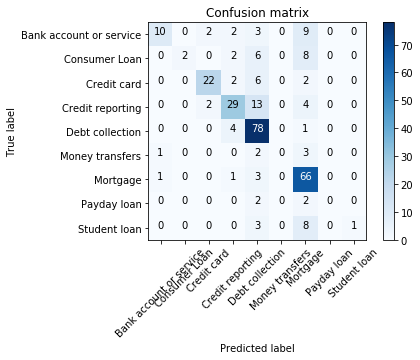

<Figure size 800x800 with 0 Axes>

In [52]:
## Check TP,TN,FP,FN
target_names = product_code_df['product'].values

## Pass actual & predicted values to the confusion matrix() - Test
cm = confusion_matrix(Y_test, lr_tfidf_pred_test)
#plt.figure()
plot_confusion_matrix(cm, classes=target_names)
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='g', edgecolor='k')
plt.show()

### Models - Comparision Graph

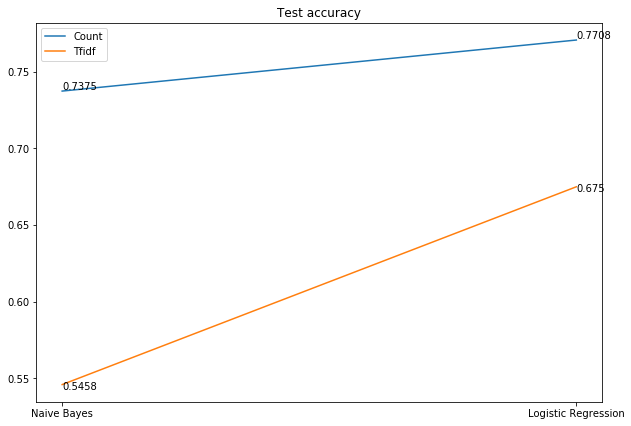

In [51]:
count = np.array([0.7375,0.7708333333333334])
tfidf = np.array([0.5458333333333333,0.675])
label_list = ["Naive Bayes","Logistic Regression"] 
plt.plot(count)
plt.plot(tfidf)
plt.xticks([0,1],label_list)

for i in range(2):
    plt.text(x=i,y=(count[i]+0.001),s= np.round(count[i],4))

for i in range(2):
    plt.text(x=i,y=tfidf[i]-0.003,s= np.round(tfidf[i],4))

plt.legend(["Count","Tfidf"])
plt.title("Test accuracy")

plt.tight_layout(pad=1,rect=(0, 0, 1.5, 1.5))
plt.show()